In [1]:
%matplotlib inline
# remember to execute this cell with Ctrl+Enter to render the plots in the notebook

# Practical 1: Keyword recognition for microcontrollers

**IMPORTANT**: Start from the file xx in the provided studio. (It duplicating normally takes ~5mins, please prepare it in your account in advance.)

Please attempt at least all non-optional questions in your chosen task set (A or B). Please submit a zip file of:


1. A text file with a publicly visible link to your notebook in Lightning AI;
2. A downloaded copy (ipynb) of your notebook ("_File_->Download->Download (.ipynb)"). You may treat this as a report: we will not be re-executing the code you used to produce the answers, unless absolutely required.


If you find yourself enjoying the material, feel free to attempt more! Provide your answers in a new cell below the question cell.

Notes: 

Usage: 
1. Please follow the web browser suggestions from Lightning AI to avoid potential incompability.
2. To train your neural networks using GPU acceleration, make sure that the runtime type is set to GPU in the _Runtime_->_Change runtime type_ menu. Further, you will see "cells" with code, which you can run either by using Ctrl+Enter or by clicking the play button in their top left corner.
3. If you fail to proceed with pytorch on lightning platform, you can access a tensorflow version of this practise in the colab platform.

## Introduction

Small computational devices, such as microcontrollers, are often used in wearable, embedded or IoT devices where we need some but not too much computational ability, like a smart doorbell, a remote control, an Apple Pencil (!), to name a few. They are extremely power efficient, but also heavily resource-constrained: "high-end" microcontrollers will have up to 2 MB of storage, 1 MB of RAM and a ~400 MHz simple single-core ARM processor. Much worse than your average smartphone or a Raspberry Pi!

We can make devices powered by microcontroller units (MCUs) "smart" by running some very small neural networks on them. In this practical, we'll focus on keyword recognition, or spotting (KWS). That is, recognising spoken words, such as "Alexa" or "OK Google". Often in these systems, microcontroller-driven KWS is just the first step in the recognition pipeline. Once a light model, running on an MCU, spots what could be an activation word, it will enable better microphones, use a larger model and a more powerful processor to do the rest of the recognition.

Progression of the practical:
1. Training a model to recognise a keyword from a predefined set of keywords. This is done using convolutional networks trained on audio recordings that are converted to spectrograms.
2. Converting a TensorFlow/Keras model into the TFLite format, suitable for deployment on a constrained device. This will optimise the model (its computation graph) and quantise its parameters (more on that later).
3. Deploying your model onto a BBC micro:bit to see how it runs!

First, let’s import the common torch packages such as
[torchaudio](https://github.com/pytorch/audio)_ that can be installed
by following the instructions on the website.


In [2]:
# Uncomment the line corresponding to your "runtime type" to run in Google Colab
# No need to re-run between different runtime refreshes.
!pip install soundfile torchaudio # this will install other dependent wheels automatically

/usr/bin/zsh: /home/zeus/miniconda3/envs/cloudspace/lib/libtinfo.so.6: no version information available (required by /usr/bin/zsh)


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys

import matplotlib.pyplot as plt
import IPython.display as ipd

from tqdm import tqdm

Let’s check if a CUDA GPU is available and select our device. Running
the network on a GPU will greatly decrease the training/testing runtime.




In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Importing the Dataset

We use torchaudio to download and represent the dataset. Here we use
[SpeechCommands](https://arxiv.org/abs/1804.03209)_, which is a
datasets of 35 commands (e.g., "Yes", "No", "Up", "Down", "Left", "Right", "On", "Off", etc.) spoken by different people. The dataset
``SPEECHCOMMANDS`` is a ``torch.utils.data.Dataset`` version of the
dataset. In this dataset, all audio files are about 1 second long (and
so about 16000 time frames long).

The actual loading and formatting steps happen when a data point is
being accessed, and torchaudio takes care of converting the audio files
to tensors. If one wants to load an audio file directly instead,
``torchaudio.load()`` can be used. It returns a tuple containing the
newly created tensor along with the sampling frequency of the audio file
(16kHz for SpeechCommands).

Going back to the dataset, here we create a subclass that splits it into
standard training, and testing subsets.

Please note: this cell downloads the Speech Commands dataset, which might take up to 10 mins depending on your network conditions.

In [5]:
from torchaudio.datasets import SPEECHCOMMANDS
import os


class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None, include_labels=None, silence_ratio=0.1, unknown_ratio=0.1):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]

        # 如果指定了 include_labels, 过滤 _walker 中的词
        if include_labels is not None:
            self._walker = [w for w in self._walker if self._get_label(w) in include_labels]

    def _get_label(self, filepath):
        # 根据文件路径推断出标签。一般文件路径中包含了标签名
        return os.path.normpath(filepath).split(os.sep)[-2]


# 你只想要的几个词，例如 "yes", "no", "up", "down"
selected_words = ["yes", "no"]
# selected_words = ["down", "go", "left", "no", "off", "on", "right", "stop", "up", "yes"]

# 创建仅包含选定词的训练和测试集
train_set = SubsetSC("training", include_labels=selected_words)
test_set = SubsetSC("testing", include_labels=selected_words)

waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]

A data point in the SPEECHCOMMANDS dataset is a tuple made of a waveform
(the audio signal), the sample rate, the utterance (label), the ID of
the speaker, the number of the utterance.




Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


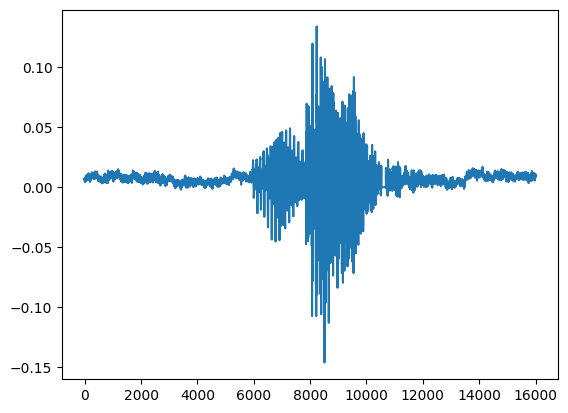

In [6]:
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy());

Let’s find the list of labels available in the dataset.




In [7]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
labels

['no', 'yes']

The audio labels are commands that are said by users.

Notes: If you can not play the audio in the lightninbg audio backend. Save it to the file and click to listen to it.

In [8]:
waveform_first, *_ = train_set[0]
ipd.Audio(waveform_first.numpy(), rate=sample_rate)

## Formatting the Data

This is a good place to apply transformations to the data. For the
waveform, we downsample the audio for faster processing without losing
too much of the classification power.

We don’t need to apply other transformations here. It is common for some
datasets though to have to reduce the number of channels (say from
stereo to mono) by either taking the mean along the channel dimension,
or simply keeping only one of the channels. Since SpeechCommands uses a
single channel for audio, this is not needed here.




In [9]:
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform)

ipd.Audio(transformed.numpy(), rate=new_sample_rate)

We are encoding each word using its index in the list of labels.




In [10]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

yes --> tensor(1) --> yes


To turn a list of data point made of audio recordings and utterances
into two batched tensors for the model, we implement a collate function
which is used by the PyTorch DataLoader that allows us to iterate over a
dataset by batches. Please see [the
documentation](https://pytorch.org/docs/stable/data.html#working-with-collate-fn)_
for more information about working with a collate function.

In the collate function, we also apply the resampling, and the text
encoding.




In [11]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

## Define the Network

For this tutorial we will use a convolutional neural network to process
the raw audio data. Usually more advanced transforms are applied to the
audio data, however CNNs can be used to accurately process the raw data.
The specific architecture is modeled after the M5 network architecture
described in [this paper](https://arxiv.org/pdf/1610.00087.pdf)_. An
important aspect of models processing raw audio data is the receptive
field of their first layer’s filters. Our model’s first filter is length
80 so when processing audio sampled at 8kHz the receptive field is
around 10ms (and at 4kHz, around 20 ms). This size is similar to speech
processing applications that often use receptive fields ranging from
20ms to 40ms.




In [12]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, int(x.shape[-1]))
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)


model = M5(n_input=transformed.shape[0], n_output=len(labels))
model.to(device)
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=2, bias=True)
)
Number

We will use the same optimization technique used in the paper, an Adam
optimizer with weight decay set to 0.0001. At first, we will train with
a learning rate of 0.01, but we will use a ``scheduler`` to decrease it
to 0.001 during training after 20 epochs.




In [13]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

## Training and Testing the Network

Now let’s define a training function that will feed our training data
into the model and perform the backward pass and optimization steps. For
training, the loss we will use is the negative log-likelihood. The
network will then be tested after each epoch to see how the accuracy
varies during the training.




In [14]:
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())

Now that we have a training function, we need to make one for testing
the networks accuracy. We will set the model to ``eval()`` mode and then
run inference on the test dataset. Calling ``eval()`` sets the training
variable in all modules in the network to false. Certain layers like
batch normalization and dropout layers behave differently during
training so this step is crucial for getting correct results.




In [15]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    # print(tensor)
    tensor = torch.tensor(tensor)
    return tensor.argmax(dim=-1)


def test(model, epoch):
    # model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        try:
          # Code that might raise an error
          output = model(data)
        except AttributeError as e:
          # Code to handle the error or simply pass
          print(f"Error: {e}")
          continue  # This will skip the error and continue execution


        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(pbar_update)

        print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")

Finally, we can train and test the network. We will train the network
for ten epochs then reduce the learn rate and train for ten more epochs.
The network will be tested after each epoch to see how the accuracy
varies during the training.




In [16]:
log_interval = 20
n_epoch = 3

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        test(model, epoch)
        scheduler.step()

# Let's plot the training loss versus the number of iteration.
# plt.plot(losses);
# plt.title("training loss");

  1%|          | 0.034482758620689655/3 [00:07<10:39, 215.69s/it]

Train Epoch: 1 [0/6358 (0%)]	Loss: 0.759760


 24%|██▍       | 0.7241379310344827/3 [02:19<06:39, 175.46s/it]  

Train Epoch: 1 [5120/6358 (80%)]	Loss: 0.285682


 29%|██▊       | 0.8620689655172411/3 [02:40<05:28, 153.61s/it]/tmp/ipykernel_1469/1869617982.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor = torch.tensor(tensor)
 30%|██▉       | 0.8965517241379307/3 [02:40<03:48, 108.74s/it]


Test Epoch: 1	Accuracy: 157/824 (19%)



 31%|███       | 0.9310344827586203/3 [02:44<03:56, 114.40s/it]


Test Epoch: 1	Accuracy: 386/824 (47%)



 32%|███▏      | 0.9655172413793099/3 [02:56<06:22, 188.02s/it]


Test Epoch: 1	Accuracy: 524/824 (64%)



 33%|███▎      | 0.9999999999999996/3 [02:59<05:05, 152.83s/it]


Test Epoch: 1	Accuracy: 550/824 (67%)



 34%|███▍      | 1.0344827586206893/3 [03:04<05:03, 154.66s/it]

Train Epoch: 2 [0/6358 (0%)]	Loss: 0.328019


 57%|█████▋    | 1.7241379310344838/3 [04:20<01:53, 88.84s/it] 

Train Epoch: 2 [5120/6358 (80%)]	Loss: 0.235518


 63%|██████▎   | 1.8965517241379324/3 [04:28<00:46, 41.92s/it]


Test Epoch: 2	Accuracy: 133/824 (16%)



 64%|██████▍   | 1.931034482758622/3 [04:29<00:47, 44.36s/it] 


Test Epoch: 2	Accuracy: 373/824 (45%)



 66%|██████▌   | 1.9655172413793118/3 [04:32<00:56, 54.31s/it]


Test Epoch: 2	Accuracy: 541/824 (66%)



 67%|██████▋   | 2.0000000000000013/3 [04:33<00:42, 42.38s/it]


Test Epoch: 2	Accuracy: 569/824 (69%)



 68%|██████▊   | 2.034482758620691/3 [04:33<00:36, 37.51s/it] 

Train Epoch: 3 [0/6358 (0%)]	Loss: 0.196974


 92%|█████████▏| 2.7586206896551704/3 [04:43<00:01,  5.43s/it]

Train Epoch: 3 [5120/6358 (80%)]	Loss: 0.209392


 98%|█████████▊| 2.931034482758618/3 [04:43<00:00,  4.14s/it] 


Test Epoch: 3	Accuracy: 132/824 (16%)


Test Epoch: 3	Accuracy: 375/824 (46%)



100%|█████████▉| 2.999999999999997/3 [04:43<00:00, 94.62s/it] 


Test Epoch: 3	Accuracy: 539/824 (65%)


Test Epoch: 3	Accuracy: 575/824 (70%)



The network should be more than 65% accurate on the test set after 2
epochs, and 85% after 21 epochs. Let’s look at the last words in the
train set, and see how the model did on it.




In [17]:
def predict(tensor):
    # Use the model to predict the label of the waveform
    tensor = tensor.to(device)
    tensor = transform(tensor)
    tensor = model(tensor.unsqueeze(0))
    tensor = get_likely_index(tensor)
    tensor = index_to_label(tensor.squeeze())
    return tensor


waveform, sample_rate, utterance, *_ = train_set[-1]
ipd.Audio(waveform.numpy(), rate=sample_rate)

print(f"Expected: {utterance}. Predicted: {predict(waveform)}.")

Expected: yes. Predicted: yes.


/tmp/ipykernel_1469/1869617982.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor = torch.tensor(tensor)


Let’s find an example that isn’t classified correctly, if there is one.




In [18]:
for i, (waveform, sample_rate, utterance, *_) in enumerate(test_set):
    output = predict(waveform)
    if output != utterance:
        ipd.Audio(waveform.numpy(), rate=sample_rate)
        print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")
        break
else:
    print("All examples in this dataset were correctly classified!")
    print("In this case, let's just look at the last data point")
    ipd.Audio(waveform.numpy(), rate=sample_rate)
    print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")

Data point #1. Expected: no. Predicted: yes.


/tmp/ipykernel_1469/1869617982.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor = torch.tensor(tensor)


In [19]:
torch.save(model.cpu(),"model.pt")

## Converting the model for MCU deployment

You've been provided with a BBC micro:bit! BBC micro:bit is a microcontroller-powered educational board, with many useful peripherals, which allow it to be used in lots of cool home projects.

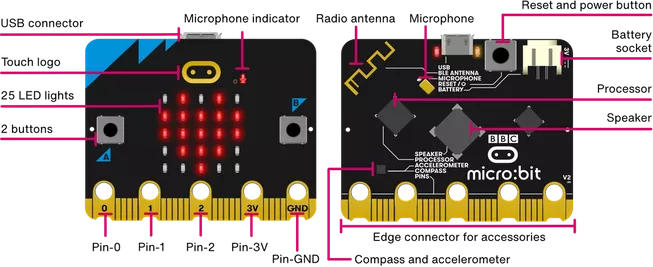

We need to take a few extra steps to ensure our model is compatible with the microcontroller environment.

### Model constraints and quantisation

We will use the TensorFlow Lite **Micro** (TFLM) runtime to run our model on a microcontroller unit (MCU). We will embed our model as a big binary blob within a program to be run by an MCU, and TFLM will read it to extract the model structure (layers) and parameters, and execute it with the supplied input.

The model has to fit within the resource constraints of an MCU:
1. Information about our model and its weights, together with the microcontroller operating system and the TFLM, have to fit within the application/Flash memory, which is 348 KB on micro:bit (remaining memory is occupied by the system software).
2. All information produced at runtime, i.e. activations of the network and memory allocated by TFLM, as well as the stack and the heap of the operating system runtime, would have to within the SRAM memory, capping it at 128 KB.

Luckily, we can reduce the memory usage of our neural network by employing *quantization*. During training, the desktop runtime uses 32-bit floating point numbers which occupy 4 bytes per element. We will quantize our model to use 8-bit integer parameters (see [affine quantization](https://arxiv.org/abs/1712.05877) if you're interested in technical details) that occupy 1 byte per element. Sometimes, microcontrollers don't have floating point computation support (though this one does), so integer quantisation becomes a necessity rather than just a space-saving measure.

Given both storage and RAM restrictions, this means that any model has to be limited in the number of weights and the peak size of its activation matrices. In practice, this number is much lower due to framework overheads, as explained above, so as a rule of thumb keep your model at < 120K parameters and < 64 K peak memory usage. We'll see later on how to measure the size of the model and its peak memory usage.

We'll convert the model from the torch format (`model.pt`) to the TensorFlow Lite format (`model.tflite`) using the provided google edge converter. 
<!-- In addition to simply changing the format and quantising the model, the converter performs model architecture optimisation, e.g. folding batch normalisation layers and element-wise operations into preceding linear operations. -->
 <!-- To determine how to quantize network activations, the converter has to have an idea of what input data might look like, and for that reason we provide the validation dataset as a _representative dataset_. -->

In [21]:

!pip install -r https://raw.githubusercontent.com/google-ai-edge/ai-edge-torch/main/requirements.txt
!pip install ai-edge-torch-nightly
import ai_edge_torch

# you can use the colab to convert if you encounter the environment issues during using ai-edge-torch-nightly
# https://colab.research.google.com/drive/1mNuEOGYEccBZL8dTlivXI8ckWUAhdIpZ?usp=sharing

/usr/bin/zsh: /home/zeus/miniconda3/envs/cloudspace/lib/libtinfo.so.6: no version information available (required by /usr/bin/zsh)
Looking in links: https://download.pytorch.org/whl/torch/, https://download.pytorch.org/whl/torchvision/, https://download.pytorch.org/whl/torchaudio/
/usr/bin/zsh: /home/zeus/miniconda3/envs/cloudspace/lib/libtinfo.so.6: no version information available (required by /usr/bin/zsh)


E0000 00:00:1729009522.218706    1469 cuda_dnn.cc:8508] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1729009522.253226    1469 cuda_blas.cc:1420] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [22]:
sample_inputs = (torch.rand((256, 1, 8000)),)
edge_model = ai_edge_torch.convert(model.eval(), sample_inputs)

I0000 00:00:1729009533.717988    1469 cpu_client.cc:467] TfrtCpuClient created.


AttributeError: module 'ml_dtypes' has no attribute 'float8_e3m4'
INFO:tensorflow:Assets written to: /tmp/tmpxbc3gewt/assets


INFO:tensorflow:Assets written to: /tmp/tmpxbc3gewt/assets
W0000 00:00:1729009535.754403    1469 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1729009535.754500    1469 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1729009535.761179    1469 mlir_graph_optimization_pass.cc:402] MLIR V1 optimization pass is not enabled


In [23]:
import sys
sys.path.append('/content')
import quant_recipes
quant_config = quant_recipes.full_int8_dynamic_recipe()
edge_model_compressed = ai_edge_torch.convert(
    model.eval(), sample_inputs, quant_config=quant_config
)

INFO:tensorflow:Assets written to: /tmp/tmpebnk57sf/assets


INFO:tensorflow:Assets written to: /tmp/tmpebnk57sf/assets
W0000 00:00:1729009540.560864    1469 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1729009540.560909    1469 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.


In [24]:
type(ai_edge_torch)

module

In [25]:
edge_model_compressed.export('model.tflite')

[Optional] We can visualise the resulting model using a tool called [Netron](https://github.com/lutzroeder/netron/releases). You can explore the model parameters by clicking on each node and looking at converted weights and quantisation parameters.

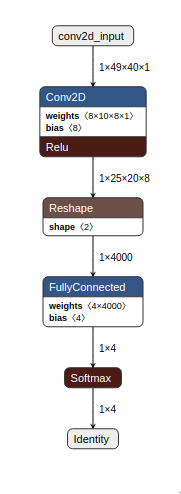

As mentioned earlier, any model to be run on an MCU should have a sufficiently small peak memory usage. During the execution, the runtime only has to store tensors for the input and the output of an operator (layer) that it's currently executing. (However, [things can get more complicated for models with branches](https://arxiv.org/abs/1910.05110), like the Inception family.)

We provide you with the `tflite-tools` toolkit to measure the peak memory usage.

In [26]:
!pip install flatbuffers prettytable

/usr/bin/zsh: /home/zeus/miniconda3/envs/cloudspace/lib/libtinfo.so.6: no version information available (required by /usr/bin/zsh)


In [27]:
# !git clone http://github.com/eliberis/tflite-tools.git

/usr/bin/zsh: /home/zeus/miniconda3/envs/cloudspace/lib/libtinfo.so.6: no version information available (required by /usr/bin/zsh)
/bin/bash: /home/zeus/miniconda3/envs/cloudspace/lib/libtinfo.so.6: no version information available (required by /bin/bash)
fatal: destination path 'tflite-tools' already exists and is not an empty directory.


⚡️ Tip	Connect GitHub to Studios: https://lightning.ai/pa511/home?settings=integrations



In [28]:
!python tflite-tools/tflite_tools.py -i model.tflite --calc-macs --calc-size

/usr/bin/zsh: /home/zeus/miniconda3/envs/cloudspace/lib/libtinfo.so.6: no version information available (required by /usr/bin/zsh)
Tensor information (weights excluded):
+----+----------------------------------------------------------------------+-------------------+-----------------+
| Id |                                Tensor                                |       Shape       | Size in RAM (B) |
+----+----------------------------------------------------------------------+-------------------+-----------------+
|  0 |                       serving_default_args_0:0                       |   (256, 1, 8000)  |       8,192,000 |
| 33 |           __main__.M5/torch.nn.modules.conv.Conv1d_conv1;1           | (256, 1, 8000, 1) |       8,192,000 |
| 34 |           __main__.M5/torch.nn.modules.conv.Conv1d_conv1;2           | (256, 1, 496, 32) |      16,252,928 |
| 35 |           __main__.M5/torch.nn.modules.conv.Conv1d_conv1;3           | (256, 32, 1, 496) |      16,252,928 |
| 36 |           _

In [29]:
# You can compare the output of transformed/compressed model with the original trained one in torch format.
torch_output = model(*sample_inputs)
edge_output = edge_model(*sample_inputs)
edge_output_compressed = edge_model_compressed(*sample_inputs)
print(torch_output[0])
print(edge_output[0])
print(edge_output_compressed[0])

tensor([[-0.9444, -0.4925]], grad_fn=<SelectBackward0>)
[[-0.9443658  -0.49253744]]
[[-0.8601022  -0.55011904]]


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


### Model export

The following will export the model into a binary blob and also display its size.
You'll need to ensure it fits within the memory, otherwise you'll get an error: please refer to the Troubleshooting section below if it happens.

In [31]:
# !apt-get update  # <-- run this if you get install errors
!apt-get -qq install xxd
!echo "Exporting model. Model size (in bytes):"
!stat --printf="%s" model.tflite
!xxd -i model.tflite > model.txt # xxd is just used to create a hex dump from model file

/usr/bin/zsh: /home/zeus/miniconda3/envs/cloudspace/lib/libtinfo.so.6: no version information available (required by /usr/bin/zsh)
/bin/bash: /home/zeus/miniconda3/envs/cloudspace/lib/libtinfo.so.6: no version information available (required by /bin/bash)
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
/usr/bin/zsh: /home/zeus/miniconda3/envs/cloudspace/lib/libtinfo.so.6: no version information available (required by /usr/bin/zsh)
Exporting model. Model size (in bytes):
/usr/bin/zsh: /home/zeus/miniconda3/envs/cloudspace/lib/libtinfo.so.6: no version information available (required by /usr/bin/zsh)
39824/usr/bin/zsh: /home/zeus/miniconda3/envs/cloudspace/lib/libtinfo.so.6: no version information available (required by /usr/bin/zsh)


In [32]:
!cat model.txt

/usr/bin/zsh: /home/zeus/miniconda3/envs/cloudspace/lib/libtinfo.so.6: no version information available (required by /usr/bin/zsh)
unsigned char model_tflite[] = {
  0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x14, 0x00, 0x20, 0x00,
  0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00, 0x0c, 0x00, 0x00, 0x00,
  0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00,
  0x84, 0x00, 0x00, 0x00, 0xdc, 0x00, 0x00, 0x00, 0x30, 0x6d, 0x00, 0x00,
  0x40, 0x6d, 0x00, 0x00, 0x60, 0x9a, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0xa2, 0x8a, 0xff, 0xff,
  0x0c, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 0x3c, 0x00, 0x00, 0x00,
  0x0f, 0x00, 0x00, 0x00, 0x73, 0x65, 0x72, 0x76, 0x69, 0x6e, 0x67, 0x5f,
  0x64, 0x65, 0x66, 0x61, 0x75, 0x6c, 0x74, 0x00, 0x01, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x98, 0xff, 0xff, 0xff, 0x4b, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x08, 0x00, 0x00, 0x00, 0x6f, 0x75, 0x74, 0x70,
  0x75, 0x74, 0x5f, 0x

Optionally, take a look at the contents of the blob. Download the `model.txt` file to your computer. Click the file icon on the left menu of this web to view all the downloaded and generated files on Google Colab Server. Right click to download the `model.txt`.

# Running the model on an MCU

## Installing the development software on your computer

The following assumes you will be using Mac OS or Linux as your operating system. If you're using Windows, you may need to do some extra work to adapt the instructions to your environment.

To prepare your machine for development, install [Docker or Docker Desktop](https://www.docker.com/products/docker-desktop).

If you prefer to use your current / host operating system to compile the software for a microcontroller, you can follow environment installation instructions in this [micro:bit samples repository](https://github.com/lancaster-university/microbit-v2-samples).

## Setting up the audio recognition project

Using the command line in your local machine, clone the project files:

`git clone https://github.com/caidongqi/microbit-speech kws_model`

and navigate into the project directory:

`cd kws_model`

Compile the software through Docker:

`DOCKER_BUILDKIT=1 docker build -t microbit-tools --output out .`

Once that has finished, copy over the resulting binary to the microcontroller (this will "flash" it):

`cp out/MICROBIT.hex /Volumes/MICROBIT`

where `/Volumes/MICROBIT` is the location of the connected micro:bit, which will be recognised as a USB storage device.

Afterwards you can see what the board outputs into the terminal over the serial port by typing:

`screen /dev/tty.usbm<device_id> 115200` (or `/dev/ttyACM<device_id>` on Linux). You can use autocomplete to figure out the device ID under which the micro:bit appears on your system this time.

(use `Ctrl+A` then `Ctrl+D` to exit from `screen`)

You can now modify files in the `kws_model` directory and compile and flash them onto the board using the commands above.

## Using the keyword recognition model

The software running on the board listens for microphone input, then runs the keyword recognition model and prints its detections over the serial port (into the terminal). The recording stage is indicated by the red microphone LED lighting up, and lasts just over 1 second.

To restart the board and start a new round of keyword recognition, press the 'RESET' button on the back of the micro:bit. If your board only outputs "silence", try speaking louder or closer to the microphone.

Try the provided model before swapping in your own. The default model is not very good --- it's your task to improve it!

## Swapping in a new model

Previously, we went through an entire model creation pipeline that produced a binary blob into the `model.txt` file with the contents of our model. To swap the default model with your new one, follow these steps:

1. Open the `model_data.cpp` file from the `kws_model` folder and the downloaded `model.txt` file in your text editor.
2. Delete the contents of the `g_model_data` array in `model_data.cpp`.
3. Copy the contents of the model array from the `model.txt` file and paste them into the now-empty `g_model_data` array. Make sure preserve the type of the `g_model_data` array: it should still say `const unsigned char g_model_data[] DATA_ALIGN_ATTRIBUTE = { ...`
4. Update `g_model_data_len` value at the bottom of `model_data.cc` with the length value you see at the bottom of the `model.txt` file. Again, make sure to preserve the type.
5. If you changed the number of outputs in the model by changing the word list:
  * update the category count in the `model_settings.h` file; it should be the number of words your model will recognise, plus 2.
  * update category labels in the `model_settings.cpp` file: add strings for the new words you've added.
6. If you used a type of layer that this practical hasn't used so far and you get operation registration errors when trying to run your model, open the `audio_inference.cc` file and find the line that creates `tflite::MicroOpResolver<N>`. This pulls operator implementations into the software (at the cost of extra space, up to 2KB per operator). Follow the example there of how other layers were added and add a layer that you're missing (assuming it is available in TFLM). Change the `N` to the number of layers you're now registering. (You can also sacrifice a lot of space and pull in all layers by deleting lines relating to `micro_op_resolver` and changing the resolver type to `AllOpsResolver`.)

## Trouble shooting

* Micro:bits v2 recognize the utterance randomly.

> Please check whether there are undefined operators in tflite source code. 

*  XNNPack delegate failed to reshape runtimeNode number 43 (TfLiteXNNPackDelegate) failed to prepare.

> It is not your failure. This might attribute to some incompatibility between the resource allocation of pytorch and tflite. Just compare the successfully evaluated samples.

* xxx
> You haven't installed any audio backends. You can install it via `!sudo apt install ffmpeg` and `!pip install pysoundfile librosa soundfile ffmpeg`. Using `print(torchaudio.list_audio_backends())` to confirm it.

* Compile/linker error `ld: region FLASH overflowed by XXXXX bytes`.

> Your model is too big! In the current version of software, you have approx. 139 KB left for your model, which includes both weights and architecture description. Keep the size (the number you paste into `model_data.cc`) under this threshold.

* `Arena size is too small` error / execution crashes / memory corruption.

> Your model's peak memory usage is too big for the micro:bit. Identify the peak using the `tflite_tools.py` code cell and reduce it. By default the tensor arena is set to 80 KB, but because of the framework overheads and inefficiencies, please keep your model peak memory usage under 64 KB.

> You can also reduce the input size by reducing `feature_bin_count` and `kFeatureSliceSize` parameters in both this notebook and microcontroller code, respectively.

* micro:bit flashes `030 :(`.

> Program execution stack corrupted the heap. Increase 'DEVICE_STACK_SIZE' in `codal.json`. If it doesn't help, refer to the previous point.

* micro:bit flashes `020 :(`.

> Your model execution is too complex. Decrease `kTensorArenaSize` in `main.cpp`: you may encounter one of the errors above, too.

* docker desktop installation `No space left on this device`.

> This refers to main memory instead of disk memory. Close some of your running application and re-launch docker desktop.

* docker on MacOS build error: request returned bad gateway for api route, check if the server supports the requested api version

> Close Docker Desktop, run the following commands:
```
rm -rf Library/Group\ Containers/group.com.docker
rm -rf Library/Containers/com.docker.docker
rm -rf Library/Application\ Support/Docker\ Desktop
```
Then restart your Docker Deskop

You can also enable debug output by setting `DMESG_SERIAL_DEBUG` and `CODAL_DEBUG` to 1 in the `codal.json` file.

# Tasks

The tasks and questions in the practicals for this course are split into two groups: A and B, with the first question applicable to both. We would like you to attempt tasks in just **one** of the groups. Feel free to attempt advanced questions, or do both groups if you find yourself enjoying the material!

* Group A: playing with neural network design to subsequent compression for a larger keyword classification problem; does not require deploying a model to an MCU, so you don't need to satisfy the model size and peak memory usage constraints.

* Group B: creating a suitably small model and deploying it to the micro:bit to recognise words of your choice.

**A1/B1.** Add one or more extra words when creating the `SpeechCommands` dataset and re-run the model training code above.
* What percentages for `silence` and `unknown` classes should you pick to obtain a balanced dataset* overall? _(*balanced s.t. these 2 classes occupy a proportionate fraction with the respect to word classes; this does not guarantee that the word classes will be balanced with respect to each other: e.g. "yes" may contain more samples than "no"; this proportion also does not guarantee the best performance at spotting keywords in practice on your hardware)_.

* Does the accuracy of the model change depending on the words (and the number of words) you choose to include? If so, what do you think could be the factors influencing the change?

### Group A



**A2.** Create a larger model that recognises the following words:

`['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes']`

You may also want to adjust the optimiser, learning rate, or use a different convolutional kernel sizes and strides for the time and frequency axes of the input. Feel free to experiment with batch normalisation, residual connections, and other common neural network architecture patterns. Aim for 90%+ validation accuracy.

Present your developed model, including its classification accuracy and its size (check `model.summary()`).


**A3.** Design a similar compressed model through one of the following:

* replace some of the deeper convolutional layers (if your model has any) with [depthwise-separable convolutions](https://www.tensorflow.org/api_docs/python/tf/keras/layers/DepthwiseConv2D) (maybe followed by 1x1 convolutions),
* distilling it into a smaller model,
* implementing and using the [Octave Convolution](https://arxiv.org/abs/1904.05049),
* or use any other model compression method or implement another efficient neural architecture / layer arrangement / feature extraction block.

You do not need to convert your model into TensorFlow Lite format or deploy it to the micro:bit.

Do you expect your newly implemented model to become faster or smaller (or both?) as a result of your changes? Discuss.

*Rough guidance for distillation:* Come up with a smaller student network. Train the larger teacher model and freeze it using `teacher_model.trainable = False`. Create a smaller student network. Now, create a new combined Keras model that calls both the teacher and the student (in parallel) on the same input and outputs the output of the student network. Add an auxiliary cross-entropy or KL-divergence loss between the teacher and student models' outputs (`teaching_loss`) that will work in addition to the regular dataset loss (for example using the `tf.keras.losses.CategoricalCrossentropy()` class and `combined_model.add_loss(teaching_loss, inputs=True)`. Also, feel free to look up how to implement distillation in Keras (or just bare TensorFlow) online, but bear in mind that some examples might be outdated.

*Rough guidance for octave convolution:* Implement it either [as a custom layer](https://www.tensorflow.org/guide/keras/custom_layers_and_models) and/or explicitly define the two paths using [the functional API](https://www.tensorflow.org/guide/keras/functional). Note: you may struggle to convert this to TFLite, because 2D-upsampling is not supported by default.

*Pointers to other architectures*: Skim through the [Hello Edge: Keyword Spotting on Microcontrollers](https://arxiv.org/abs/1711.07128) paper for inspiration or other papers that cite it.

*Note on other frameworks*: If you prefer, you can use another deep learning framework. You may find it useful to reuse the data input pipeline: use `for image_batch, labels in train_data.as_numpy_iterator()` to iterate through an epoch of data.

*Note on other frameworks*: If you prefer, you can use another deep learning framework. You may find it useful to reuse the data input pipeline: use `for image_batch, labels in train_data.as_numpy_iterator()` to iterate through an epoch of data.

**A4.** Design at least two compressed models using different compression techniques listed in A3 (For example, one model uses distilling, the other one uses octave convolution). Compare their accuracy, model size, and operations counts (Multiply-Add operations). List the advantages and disadvantages of the compression techniques you are comparing.

Group A answers: (type in your answers here)

### Group B
**B2:** Play around with the architecture of the model and the training parameters. Aim for at least 5 words of your choice (informed by question B1). In your investigation, you may consider the following:

1. Using a fully-connected model (only `Flatten` and `Dense` layers, extra helpful layers like `BatchNormalization` and `Dropout` are also allowed).

2. A larger convolutional network than the one already given (e.g. try adding more `Conv2D` layers with different parameters and `BatchNormalization` layers between `Conv2D` and `Activation('relu')`).

3. Tuning the number of epochs, the optimizer and the learning rate at each epoch. Tip: You may find the [`tf.keras.callbacks.LearningRateScheduler`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler) callback useful.

4. Skim through the [Hello Edge: Keyword Spotting on Microcontrollers](https://arxiv.org/abs/1711.07128) paper for inspiration.

Present **any three** neural networks that you've implemented as a part of your investigation. Make sure they fit within resource constraints of your device. What's the architecture of the network, the number of words it recognises, and its accuracy? Your models should be able to reach over 90% validation accuracy.

**B3.** Find a way measure the amount of time taken by the model, that is the time difference of before and after the `TfLiteStatus invoke_status = interpreter.Invoke();` line in `audio_inference.cc`.

**B4.** Compare the speed (using the method in B3), model size and operation counts (Multiply-Add operations) of the three models you develop.


You get to keep the BBC micro:bit---have fun with it and build something cool! Check out the [micro:bit website](https://www.microbit.org/) for inspiration, and the [C++ API](https://rneacy.dev/mbv2/).


Group B answers: (type in your answers here)

(c) 2024 Dongqi Cai. Licence CC BY 4.0. Material adapted from [L46 2022 produced by Edgar Liberis](https://colab.research.google.com/drive/1Ox0DMlSgA12jlK0xXXshHOWv0aeonbxl?usp=sharing), [Speech Command Classification with torchaudio](https://www.bing.com/search?q=torch+audio+classification&form=APMCS1&PC=APMC), [TensorFlow Lite Micro speech example](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/speech_commands) and TensorFlow tutorial on [post-training quantisation](https://www.tensorflow.org/lite/performance/post_training_quantization).